Steps are:

- select a reconstruction time
- the code determines which paleogeography stage this falls within, gets the start and end times
- load the relevant precomputed multipoint files, and in the process assign an integer to the different types for use in interpolation steps (e.g. set land to be 1, shallow marine to be 2, etc)

- for land and marine



In [40]:
import pygplates
import glob, re
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import xarray as xr

import polygon_processing as pp
import paleogeography as pg
import paleogeography_tweening as pgt

from proximity_query import *
from create_gpml import create_gpml_regular_long_lat_mesh
import points_in_polygons
from sphere_tools import sampleOnSphere
import points_spatial_tree



%matplotlib inline


reconstruction_time = 70.

reconstruction_basedir = '/Users/Simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles/'
tween_basedir = './tween_feature_collections/'

output_dir = './paleotopo_grids/'

area_threshold = 0.001

sampling = 0.5

#rotation_model = pygplates.RotationModel(['%s/Global_EB_250-0Ma_GK07_Matthews++.rot' % reconstruction_basedir,
#                                          '%s/Global_EB_410-250Ma_GK07_Matthews++.rot' % reconstruction_basedir])
rotation_model = pygplates.RotationModel('/Users/Simon/GIT/gplates-web-service/django/GWS/DATA/MODELS/MULLER2016/Global_EarthByte_230-0Ma_GK07_AREPS.rot')


COBterrane_file = '/Users/Simon/Data/EByteSVN/EByteDeformingModels/Matthews++_410-0Ma/StaticGeometries/AgeGridInput/Global_EarthByte_GeeK07_COB_Terranes_Matthews_etal.gpml'

agegrid_file_template = '/Users/Simon/Data/AgeGrids/Agegrids_30m_20151002_2015_v1_r756/agegrid_30m_%d.grd'


depth_for_unknown_ocean = -1000
max_mountain_elevation = 3000.


####################################################

# make a sorted list of the (midpoint) times for paleogeography polygons
tmp = glob.glob('%s/*/' % reconstruction_basedir)

time_list = []
for tm in tmp:
    time_list.append(float(re.findall(r'\d+Ma+',tm)[1][:-2]))

time_list.sort()

time_list = np.array(time_list)



In [57]:
def write_xyz_file(output_filename, output_data):
    with open(output_filename, 'w') as output_file:
        for output_line in output_data:
            output_file.write(' '.join(str(item) for item in output_line) + '\n')


# define a function that loads paleogeography multipoints at a specified time
# NOTE this time can be anything, not a time where the multipoints fit nicely together,
# hence the gaps and overlaps will be present
def add_reconstructed_points_to_xyz(points_file,rotation_model,reconstruction_time,zval):
    
    reconstructed_points = []
    pygplates.reconstruct(points_file,rotation_model,reconstructed_points,reconstruction_time)
    
    point_array = []
    for reconstructed_point in reconstructed_points:
        point_array.append(reconstructed_point.get_reconstructed_geometry().to_lat_lon_array())
        
    print points_file
    xy_array = np.vstack(point_array)
    xyz_array = np.hstack((xy_array,zval*np.ones((xy_array.shape[0],1))))
    
    return xyz_array


def get_distance_to_mountain_edge(point_array,reconstruction_basedir,time):
    
    distance_threshold_radians=None
    env_list = ['m']

    pg_dir = '%s/PresentDay_Paleogeog_Matthews2016_%dMa/' % (reconstruction_basedir,time)

    pg_features = pg.load_paleogeography(pg_dir,env_list)
    cf = pp.merge_polygons(pg_features,rotation_model,time=time,sampling=0.25)
    sieve_polygons_t1 = pp.polygon_area_threshold(cf,area_threshold)

    polygons_as_list = []
    for feature in sieve_polygons_t1:
        polygons_as_list.append(feature.get_geometry())
        
    res1 = find_closest_geometries_to_points([pygplates.PointOnSphere(point) for point in zip(point_array[:,0],point_array[:,1])],
                                             polygons_as_list,
                                             distance_threshold_radians = distance_threshold_radians)
    
    distance_to_polygon_boundary = np.degrees(np.array(zip(*res1)[0]))

    # Make a copy of list of distances.
    distance_to_polygon = list(distance_to_polygon_boundary)

    # Set distance to zero for any points inside a polygon (leave other points unchanged).
    res2 = points_in_polygons.find_polygons([pygplates.PointOnSphere(point) for point in zip(point_array[:,0],point_array[:,1])],
                                            polygons_as_list)

    for point_index, rpolygon in enumerate(res2):
        # If not inside any polygons then result will be None.
        if rpolygon is None:
            distance_to_polygon[point_index] = 0.0
            
    return distance_to_polygon


# This cell uses COB Terranes to make a masking polygon
# (which is called 'seive_polygons')
def get_merged_cob_terrane_polygons(COBterrane_file,reconstruction_time,sampling):

    polygon_features = pygplates.FeatureCollection(COBterrane_file)

    cobter = pp.force_polygon_geometries(polygon_features)

    cf = pp.merge_polygons(cobter,rotation_model,time=reconstruction_time,sampling=sampling)
    sieve_polygons = pp.polygon_area_threshold(cf,area_threshold)

    return sieve_polygons



# use merged seive_polygons to get a regular lat-long multipoint that will contain points
# only within the COB Terranes (ie not within the 'deep ocean')
def get_land_sea_multipoints(sieve_polygons,sampling):

    multipoints = create_gpml_regular_long_lat_mesh(sampling)
    grid_dims = (int(180/sampling)+1,int(360/sampling)+1)

    for multipoint in multipoints:
        for mp in multipoint.get_all_geometries():
            points = mp.to_lat_lon_point_list()

    #reconstructed_polygons = []
    #pygplates.reconstruct(cobter,rotation_model,reconstructed_polygons,reconstruction_time)

    rpolygons = []
    for polygon in sieve_polygons:
        if polygon.get_geometry():
            rpolygons.append(polygon.get_geometry())

    polygons_containing_points = points_in_polygons.find_polygons(points, rpolygons, subdivision_depth=2)

    lat = []
    lon = []
    zval = []

    lat_deep = []
    lon_deep = []
    zval_deep = []

    for pcp,point in zip(polygons_containing_points,points):
        if pcp is not None:
            lat.append(point.get_latitude())
            lon.append(point.get_longitude())
        else:
            lat_deep.append(point.get_latitude())
            lon_deep.append(point.get_longitude())
            zval_deep.append(depth_for_unknown_ocean)
            
    plt.figure(figsize=(25,11))      
    plt.plot(lon,lat,'.')
    
    plt.figure(figsize=(25,11))      
    plt.plot(lon_deep,lat_deep,'.')
    
    plt.figure(figsize=(25,11))  
    for polygon in rpolygons:
        plt.plot(polygon.to_lat_lon_array()[:,1],
                 polygon.to_lat_lon_array()[:,0])
        
            
    return lat,lon,zval,lat_deep,lon_deep,zval_deep



Working on Time 126.00Ma

Selected Time is in the stage 126.00Ma to 140.00Ma
./tween_feature_collections//tweentest_land_126.00Ma_140.00Ma.gpmlz
./tween_feature_collections//tweentest_ocean_126.00Ma_140.00Ma.gpmlz
./tween_feature_collections//mountain_regression_126.00Ma_140.00Ma.gpmlz
./tween_feature_collections//mountain_stable_126.00Ma_140.00Ma.gpmlz
['/Users/Simon/Data/GPlates/PublishedModels/WCao_Paleogeography/Supplements/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_126Ma/m_fig46_135_117_PresentDay_Paleogeog_Matthews2016_126.00Ma.shp']


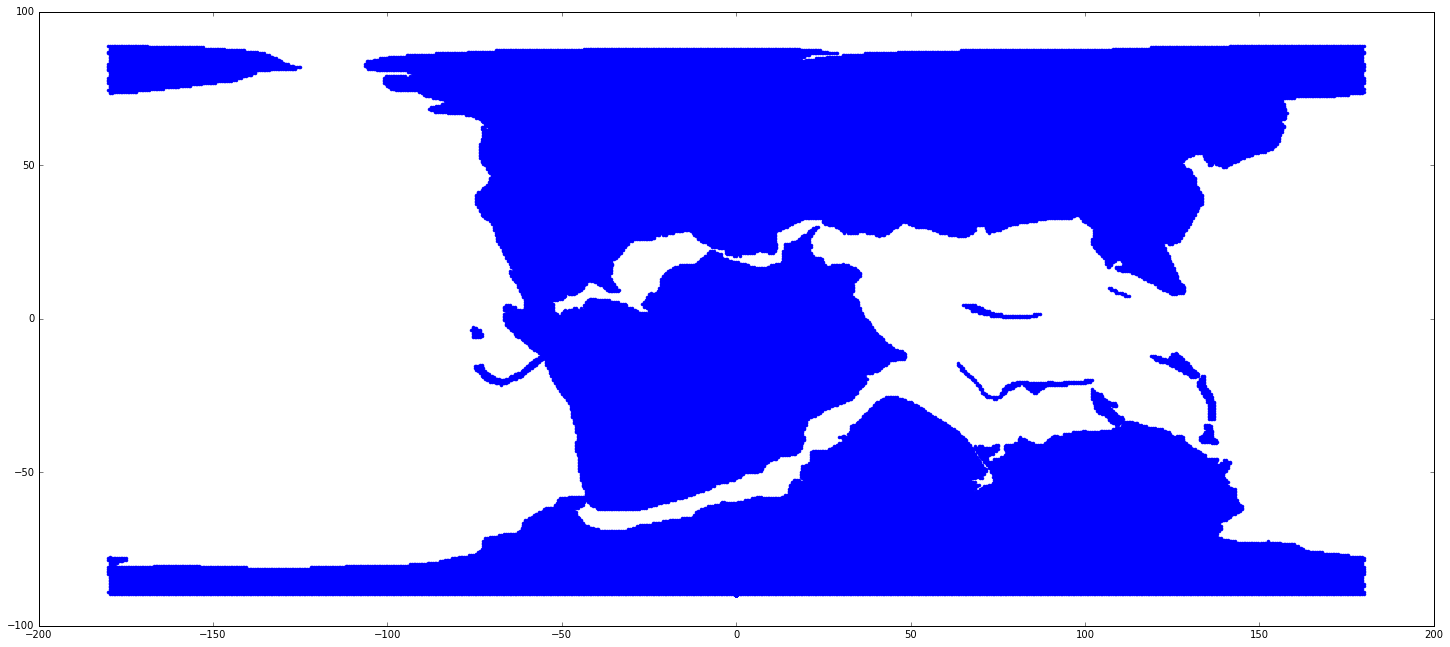

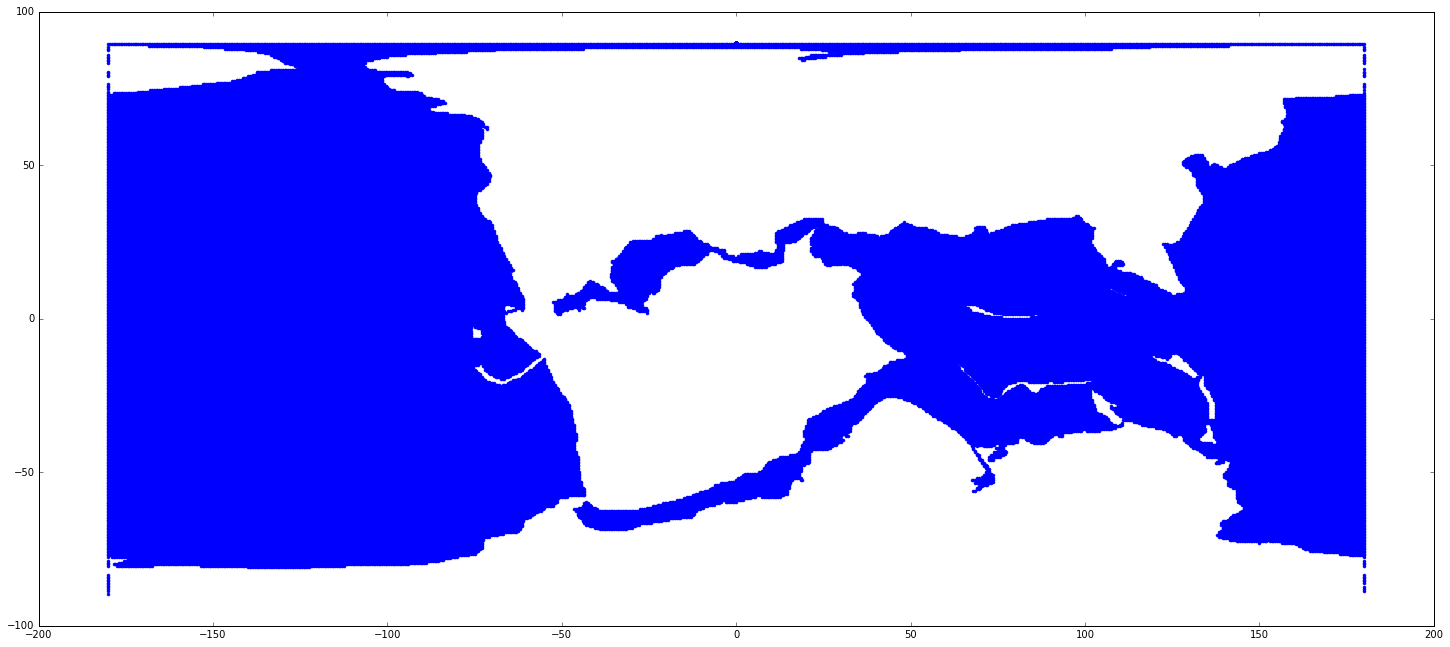

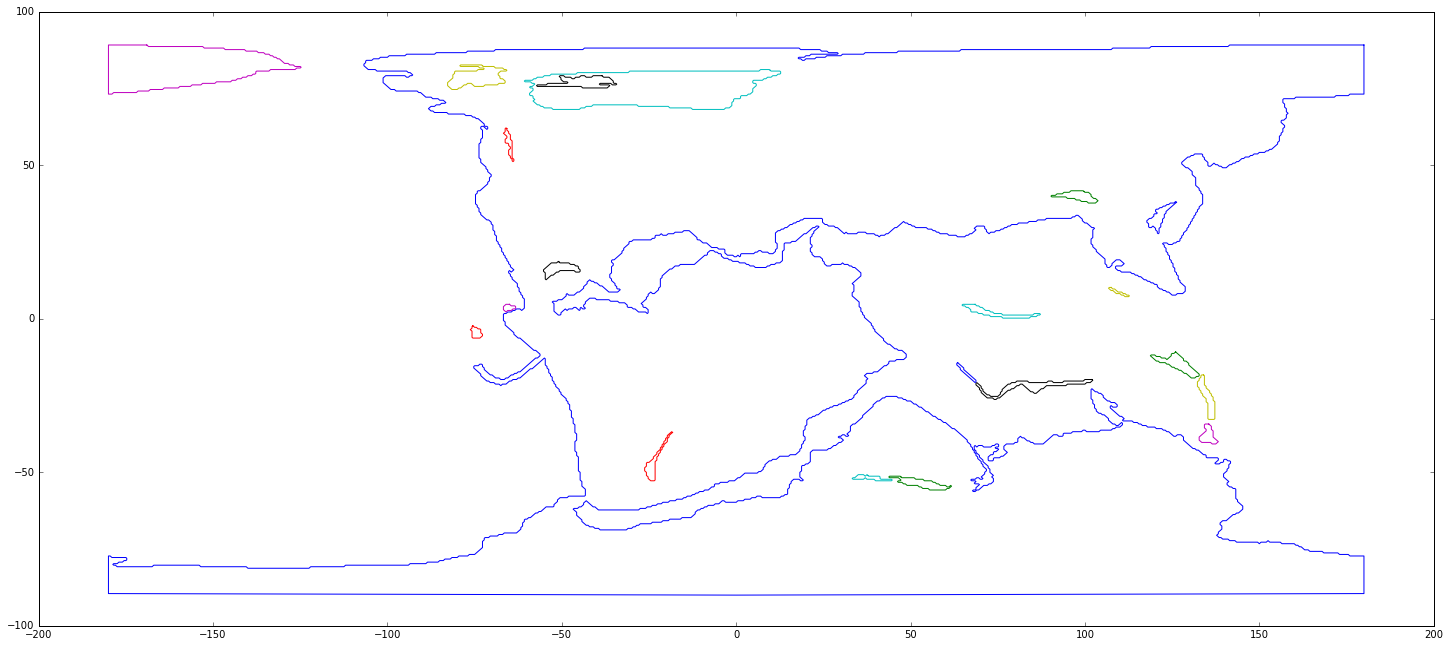

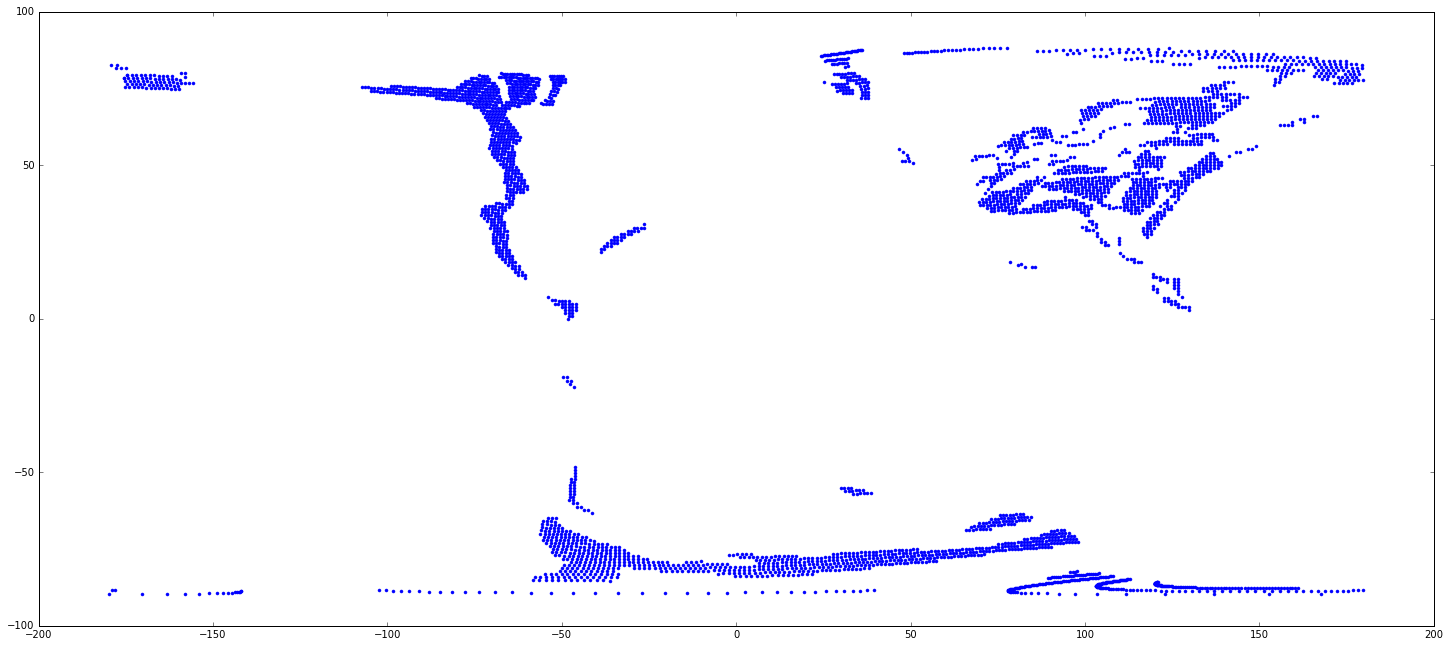

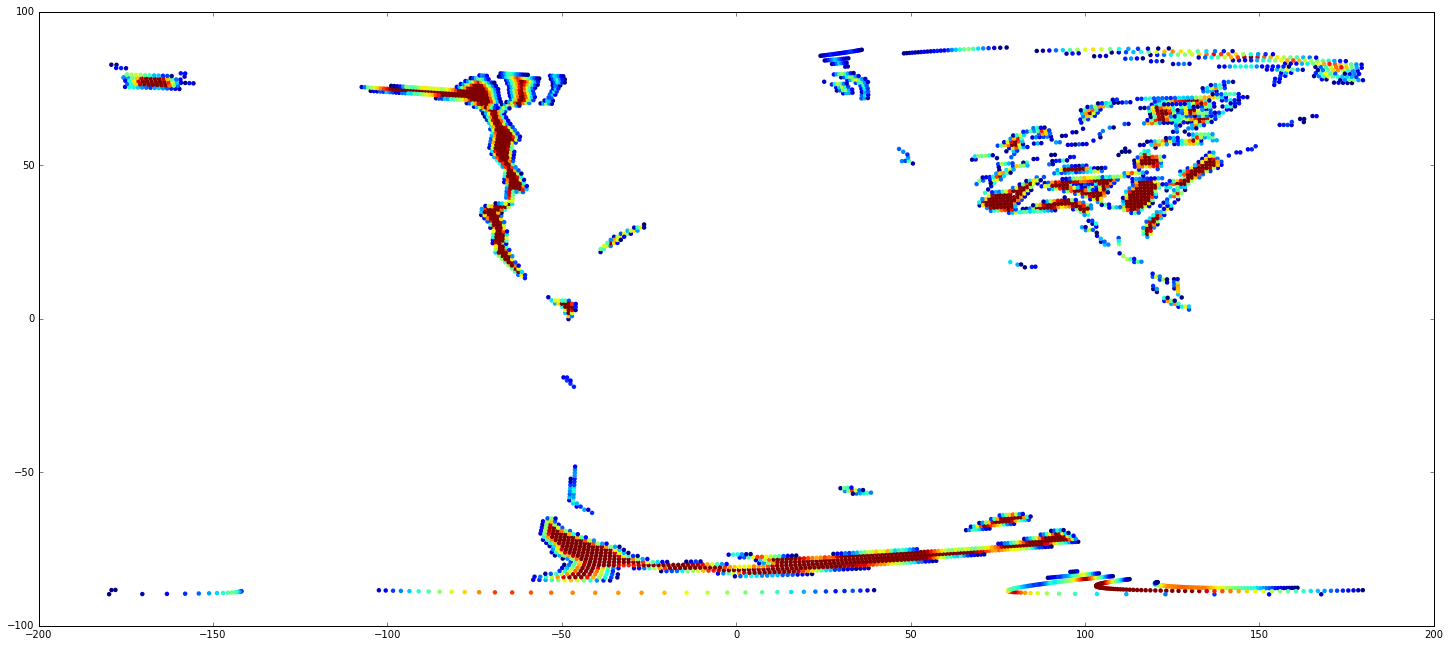

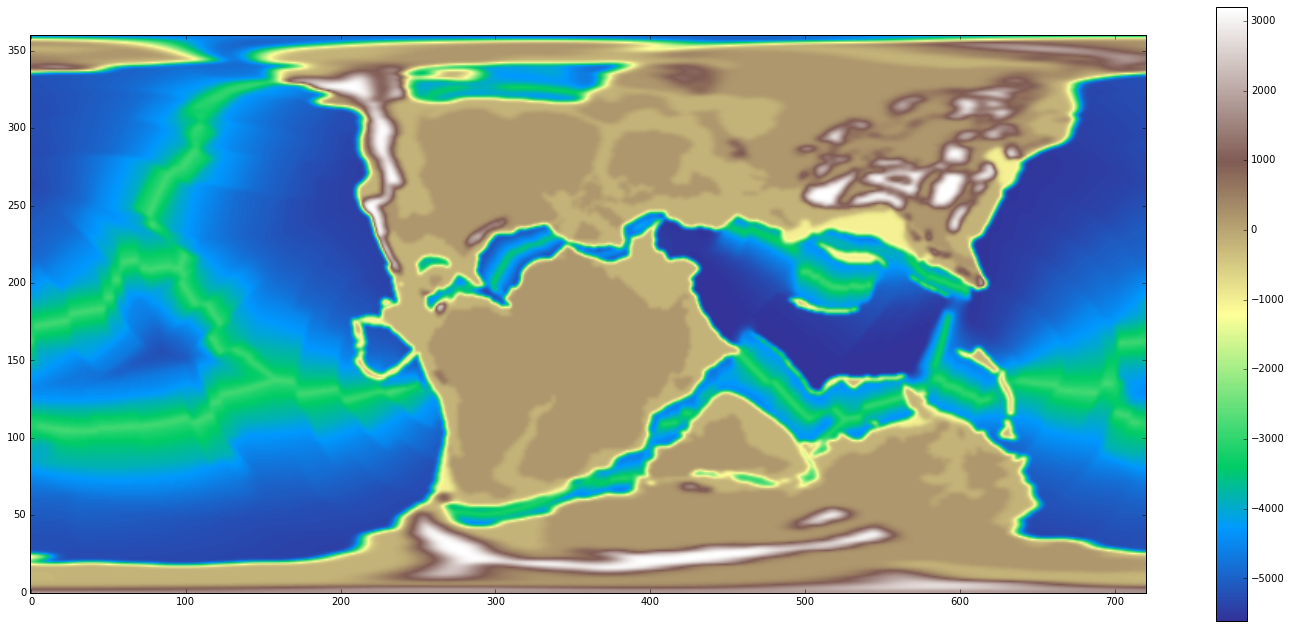

In [70]:
for reconstruction_time in np.arange(0,231,1):

    print 'Working on Time %0.2fMa\n' % reconstruction_time 
        
    # find times that bracket the selected exact time in the paleogeography source files
    time_stage_max = time_list[np.where(time_list>reconstruction_time)[0][0]]
    time_stage_min = time_list[np.where(time_list<=reconstruction_time)[0][-1]]

    
    print 'Selected Time is in the stage %0.2fMa to %0.2fMa' % (time_stage_min,time_stage_max)


    land_points_file = '%s/tweentest_land_%0.2fMa_%0.2fMa.gpmlz' % (tween_basedir,time_stage_min,time_stage_max)
    marine_points_file = '%s/tweentest_ocean_%0.2fMa_%0.2fMa.gpmlz' % (tween_basedir,time_stage_min,time_stage_max)
    mountains_going_up_file = '%s/mountain_transgression_%0.2fMa_%0.2fMa.gpmlz' % (tween_basedir,time_stage_min,time_stage_max)
    mountains_going_down_file = '%s/mountain_regression_%0.2fMa_%0.2fMa.gpmlz' % (tween_basedir,time_stage_min,time_stage_max)
    mountains_stable_file = '%s/mountain_stable_%0.2fMa_%0.2fMa.gpmlz' % (tween_basedir,time_stage_min,time_stage_max)

    
    land_point_array = add_reconstructed_points_to_xyz(land_points_file,rotation_model,reconstruction_time,200)
    marine_point_array = add_reconstructed_points_to_xyz(marine_points_file,rotation_model,reconstruction_time,-200)

    pg_point_array = np.vstack((land_point_array,marine_point_array))


    sieve_polygons = get_merged_cob_terrane_polygons(COBterrane_file,reconstruction_time,sampling)

    (lat,lon,zval,
     lat_deep,lon_deep,zval_deep) = get_land_sea_multipoints(sieve_polygons,sampling)


    # sample the land/marine points onto the points within the COB Terranes
    # This will fill the gaps that exist within continents, and average out overlaps

    d,l = sampleOnSphere(pg_point_array[:,0],pg_point_array[:,1],pg_point_array[:,2],
                         np.array(lat),np.array(lon),n=1)

    land_marine_interp_points = pg_point_array[:,2].ravel()[l]


    
    # Deal with the mountains
    if np.equal(reconstruction_time,time_stage_min):
        #dat3 = add_reconstructed_points_to_xyz(mountains_going_up_file,rotation_model,reconstruction_time,3)
        dat4 = add_reconstructed_points_to_xyz(mountains_going_down_file,rotation_model,reconstruction_time,3)
        dat5 = add_reconstructed_points_to_xyz(mountains_stable_file,rotation_model,reconstruction_time,3)
        mountains_tr_point_array = np.vstack((dat4,dat5))
        
        dist_tr = get_distance_to_mountain_edge(mountains_tr_point_array,reconstruction_basedir,reconstruction_time)
        dist_tr_cap = np.array(dist_tr)
        dist_tr_cap[np.array(dist_tr)>1.] = 1.

        normalized_mountain_elevation = dist_tr_cap
        
    else:
        # load in the mountain points but at three different times: t1 and t2, and the reconstruction time
        # note that these three arrays should all be identical in size, since they are the same multipoints
        # just reconstructed to three slightly different times
        dat3 = add_reconstructed_points_to_xyz(mountains_going_up_file,rotation_model,time_stage_max,3)
        dat4 = add_reconstructed_points_to_xyz(mountains_going_down_file,rotation_model,time_stage_max,3)
        dat5 = add_reconstructed_points_to_xyz(mountains_stable_file,rotation_model,time_stage_max,3)
        mountains_t2_point_array = np.vstack((dat3,dat4,dat5))

        dat3 = add_reconstructed_points_to_xyz(mountains_going_up_file,rotation_model,time_stage_min+0.01,3)
        dat4 = add_reconstructed_points_to_xyz(mountains_going_down_file,rotation_model,time_stage_min+0.01,3)
        dat5 = add_reconstructed_points_to_xyz(mountains_stable_file,rotation_model,time_stage_min+0.01,3)
        mountains_t1_point_array = np.vstack((dat3,dat4,dat5))

        dat3 = add_reconstructed_points_to_xyz(mountains_going_up_file,rotation_model,reconstruction_time,3)
        dat4 = add_reconstructed_points_to_xyz(mountains_going_down_file,rotation_model,reconstruction_time,3)
        dat5 = add_reconstructed_points_to_xyz(mountains_stable_file,rotation_model,reconstruction_time,3)
        mountains_tr_point_array = np.vstack((dat3,dat4,dat5))

        # calculate distances of the mountain points to the edge of the mountain region at t1 and t2,
        # using the pg polygons that they should exactly correspond to 
        dist_t1 = get_distance_to_mountain_edge(mountains_t1_point_array,reconstruction_basedir,time_stage_min)
        dist_t2 = get_distance_to_mountain_edge(mountains_t2_point_array,reconstruction_basedir,time_stage_max)


        # cap the distances at some arbitrary value
        dist_t1_cap = np.array(dist_t1)
        dist_t1_cap[np.array(dist_t1)>1.] = 1.

        dist_t2_cap = np.array(dist_t2)
        dist_t2_cap[np.array(dist_t2)>1.] = 1.

        # get the normalised time within this time stage
        # for example we are at 0.25 between the t1 and t2
        t_diff = (time_stage_max-time_stage_min)
        t_norm = (reconstruction_time-time_stage_min)/t_diff
        print t_diff, t_norm

        # use 1d interpolation to get the 'normalized' height of the mountains at the preceding
        # and subsequent times to the specific reconstruction time
        # [note this is not spatial interpolation - rather it is interpolation at each individual point
        # between the heights at earlier and later times]
        tmp = np.vstack((dist_t1_cap,dist_t2_cap))
        f = interpolate.interp1d([0,1],tmp.T)
        normalized_mountain_elevation = f(t_norm)
    
    
    plt.figure(figsize=(25,11))
    plt.plot(mountains_tr_point_array[:,1],mountains_tr_point_array[:,0],'.')
    
    # interpolate the elevations at tr onto the regular long lat points that we will ultimately use 
    # for the grid output
    # note the k value here controls number of neighbouring points used in inverse distance average
    d,l = sampleOnSphere(mountains_tr_point_array[:,0],mountains_tr_point_array[:,1],normalized_mountain_elevation,
                         np.array(lat),np.array(lon),k=4)
    w = 1./d**2
    normalized_mountain_elevation_interp_points = np.sum(w * normalized_mountain_elevation.ravel()[l],axis=1) / np.sum(w,axis=1)

    mountain_buffer_distance_degrees = 1.
    mountain_proximity_index = np.degrees(np.min(d,axis=1))<mountain_buffer_distance_degrees

    plt.figure(figsize=(25,11))
    plt.scatter(mountains_tr_point_array[:,1],mountains_tr_point_array[:,0],
                c=normalized_mountain_elevation,edgecolor='')

    write_xyz_file('land_marine.xyz',zip(lon+lon_deep,
                                         lat+lat_deep,
                                         np.hstack((land_marine_interp_points,zval_deep))))

    mountain_elevation_factor = max_mountain_elevation/mountain_buffer_distance_degrees
    write_xyz_file('mountain.xyz',zip(np.array(lon)[mountain_proximity_index],
                                      np.array(lat)[mountain_proximity_index],
                                      normalized_mountain_elevation_interp_points[mountain_proximity_index]*mountain_elevation_factor))


    os.system('gmt xyz2grd land_marine.xyz -Gland_marine.nc -Rd -I%0.8f' % sampling)
    os.system('gmt xyz2grd mountain.xyz -Gmountain.nc -Rd -I%0.8f -di0' % sampling)
    os.system('gmt grdmath mountain.nc land_marine.nc ADD = paleotopo.nc')

    topoX,topoY,topoZ = pg.load_netcdf('paleotopo.nc')


    # load age grid for this time and calculate paleobathymetry
    agegrid_file = agegrid_file_template % reconstruction_time

    ageX,ageY,ageZ = pg.load_netcdf(agegrid_file)

    paleodepth = pg.age2depth(ageZ,model='GDH1')


    # get index for grid nodes where age grid is nan, replace values with topography/shallow bathymetry
    not_bathy_index = np.isnan(paleodepth)

    paleodepth[not_bathy_index] = topoZ[not_bathy_index]


    foo = xr.DataArray(paleodepth,
                       coords=[('lat',topoY),('lon',topoX)])
    #foo.name = 'z'
    foo.to_netcdf('paleotopobathy.nc',format='NETCDF3_CLASSIC')

    pg.smooth_topography_grid('paleotopobathy.nc','paleotopobathy_smooth_%0.2fMa.nc' % reconstruction_time,400.)
    os.system('grdfilter %s -G%s -Fg%0.2f -D4 -Vl' % ('paleotopobathy.nc',
                                                      '%s/paleotopobathy_smooth_%0.2fMa.nc' % (output_dir,reconstruction_time),
                                                      400.))

    topo_smoothX,topo_smoothY,topo_smoothZ = pg.load_netcdf('%s/paleotopobathy_smooth_%0.2fMa.nc' % (output_dir,reconstruction_time))
    #
    plt.figure(figsize=(25,11))
    plt.imshow(topo_smoothZ,origin='lower',cmap=plt.cm.terrain)
    plt.colorbar()

    break
    